##### This notebook performs comprehensive EDA (Exploratory Data Analysis) on S&P 500 datasets including company fundamentals, index performance, and stock prices.
This includes:

a) Loads and validates the dataset files

b) Displays data structure, types, and missing values

c) Visualizes categorical distributions and missing data patterns

d) Applies and visualizes log transformations for skewed numerical features

e) Compares stock price performance against S&P 500 index

f) Shows correlation analysis and pairwise distributions

g) Compares return patterns between individual stocks and the index

# Installs required Python libraries used throughout the notebook.

In [ ]:
!pip install scipy
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib

# Imports data handling, visualization, and statistics libraries.

In [40]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skew
import matplotlib.pyplot as plt
from IPython.display import display

# All Constants

In [41]:
# Constructs full paths for CSV data files.
DATA_DIR = os.path.join('..', 'data') #this will make sure this file can be accessed on naanyy plateform
SNP500_COMPANIES_FILE_PATH = os.path.join(DATA_DIR, 'sp500_companies.csv')
SNP500_INDEX_FILE_PATH     = os.path.join(DATA_DIR, 'sp500_index.csv')
SNP500_STOCKS_FILE_PATH    = os.path.join(DATA_DIR, 'sp500_stocks.csv')

# Reads the three S&P 500 related datasets and checks file existence.

In [42]:
def loadDataset(paths):
    """
    Loads CSV files from specified paths into pandas DataFrames.
    Returns a tuple of DataFrames: (companies, index, stocks).
    Raises FileNotFoundError if any file path does not exist.
    """
    print("Loading all dataframe.")
    # Check file existence
    for file_path in paths:
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
    return pd.read_csv(paths[0]), pd.read_csv(paths[1], parse_dates=["Date"]), pd.read_csv(paths[2], parse_dates=["Date"])

file_paths = [SNP500_COMPANIES_FILE_PATH, SNP500_INDEX_FILE_PATH, SNP500_STOCKS_FILE_PATH]
df_sp500_companies, df_sp500_index, df_sp500_stocks = loadDataset(file_paths)

Loading all dataframe.


# Explore Dataframe
##### Print schema and sample records for each dataset.

In [43]:
def explore_columns_datatype(df, df_name="DataFrame"):
    """
    Prints column names, data types, and a data preview (head) for the given DataFrame.
    Also prints date range if a 'Date' column is present.
    """
    print(f"\n *********************  Overview of {df_name} *********************")

    print("\nColumn Names:")
    display(list(df.columns))

    print("\nColumn Data Types:")
    display(df.dtypes)

    print("\nFirst 5 Rows:")
    display(df.head())

    if 'Date' in df.columns:    
        print("Min Date:", df['Date'].min())
        print("Max Date:", df['Date'].max())

### Explore S&P500 Stocks Dataframe column, Column data type

#### Columns Present:


**Date:** Timestamp indicating the trading day.

**Symbol:** Ticker symbol for the company.

**Adj Close:** Adjusted closing price (used for dividends/splits, currently all NaN).

**Close, High, Low, Open:** Daily price metrics.

**Volume:** Shares traded.


#### Date Range:

From 2010-01-04 to 2024-12-20, covering nearly 15 years of data.


In [44]:
explore_columns_datatype(df_sp500_stocks, "S&P500 Stocks")


 *********************  Overview of S&P500 Stocks *********************

Column Names:


['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']


Column Data Types:


Date         datetime64[ns]
Symbol               object
Adj Close           float64
Close               float64
High                float64
Low                 float64
Open                float64
Volume              float64
dtype: object


First 5 Rows:


,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,MMM,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-06,MMM,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-07,MMM,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-08,MMM,NaN,NaN,NaN,NaN,NaN,NaN


Min Date: 2010-01-04 00:00:00
Max Date: 2024-12-20 00:00:00


### Explore S&P500 Index Dataframe column, Column data type

The S&P500 Index dataset contains daily index values over a 10-year span, from December 22, 2014 to December 20, 2024. Each row captures the market value of the S&P 500 on a specific trading day. The data is well-structured with no missing columns and consistent datetime formatting. The steady growth in values across rows (as seen in the preview) hints at broader upward trends, which is expected in a long-term index. 

#### Columns Present

**Date:** The specific trading day (market date) on which the S&P 500 index value was recorded.
**S&P500:** The closing value of the S&P 500 index on that particular date, representing the overall performance of 500 large-cap U.S. companies.


**Date Range:**

Minimum Date: 2014-12-22

Maximum Date: 2024-12-20

In [45]:
explore_columns_datatype(df_sp500_index, "S&P500 Index")



 *********************  Overview of S&P500 Index *********************

Column Names:


['Date', 'S&P500']


Column Data Types:


Date      datetime64[ns]
S&P500           float64
dtype: object


First 5 Rows:


,Date,S&P500
0,2014-12-22,2078.54
1,2014-12-23,2082.17
2,2014-12-24,2081.88
3,2014-12-26,2088.77
4,2014-12-29,2090.57


Min Date: 2014-12-22 00:00:00
Max Date: 2024-12-20 00:00:00


### Explore S&P500 Companies Dataframe column, Column data type

This dataset provides detailed company-level metadata for all the constituents of the S&P 500 index. It includes information about their exchange, financial metrics, sector/industry classification, and geographical/business presence.

#### Columns Present
**Exchange:**	The stock exchange where the company is listed (e.g., NYSE, NASDAQ).

**Symbol:**	The stock ticker symbol that uniquely identifies each company.

**Shortname:**	Abbreviated or commonly used name of the company.

**Longname:**	Full legal name of the company.

**Sector:**	The broad business category the company operates in (e.g., Technology, Healthcare).

**Industry:**	The specific industry within the sector.

**Currentprice:**	The latest available market price per share of the company's stock.

**Marketcap:**	The company's total market capitalization (i.e., share price × number of shares outstanding).

**Ebitda:**	Earnings before interest, taxes, depreciation, and amortization — a measure of operating profitability.

**Revenuegrowth:**	Percentage growth in revenue over a recent period, indicating business expansion or contraction.

**City:**	The city where the company is headquartered.

**State:**	The state or region of the company’s headquarters (if applicable).

**Country:**	The country where the company is based.

**Fulltimeemployees:**	Total number of full-time employees in the company.

**Longbusinesssummary:**	A detailed textual summary describing the company's business operations and scope.

**Weight:**	The company’s weight in the S&P 500 index, based on its market cap relative to the index.


In [46]:
explore_columns_datatype(df_sp500_companies, "S&P500 Companies")



 *********************  Overview of S&P500 Companies *********************

Column Names:


['Exchange',
 'Symbol',
 'Shortname',
 'Longname',
 'Sector',
 'Industry',
 'Currentprice',
 'Marketcap',
 'Ebitda',
 'Revenuegrowth',
 'City',
 'State',
 'Country',
 'Fulltimeemployees',
 'Longbusinesssummary',
 'Weight']


Column Data Types:


Exchange                object
Symbol                  object
Shortname               object
Longname                object
Sector                  object
Industry                object
Currentprice           float64
Marketcap                int64
Ebitda                 float64
Revenuegrowth          float64
City                    object
State                   object
Country                 object
Fulltimeemployees      float64
Longbusinesssummary     object
Weight                 float64
dtype: object


First 5 Rows:


,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,254.49,3846819807232,1.346610e+11,0.061,Cupertino,CA,United States,164000.0,"Apple Inc. designs, manufactures, and markets ...",0.069209
1,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,134.70,3298803056640,6.118400e+10,1.224,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.059350
2,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,436.60,3246068596736,1.365520e+11,0.160,Redmond,WA,United States,228000.0,Microsoft Corporation develops and supports so...,0.058401
3,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,224.92,2365033807872,1.115830e+11,0.110,Seattle,WA,United States,1551000.0,"Amazon.com, Inc. engages in the retail sale of...",0.042550
4,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,191.41,2351625142272,1.234700e+11,0.151,Mountain View,CA,United States,181269.0,Alphabet Inc. offers various products and plat...,0.042309


# Identifies columns with missing values and displays stats.

Financial features such as Ebitda and Revenuegrowth are missing for a few companies. Since these are important for financial modeling, imputation or exclusion may be necessary.
Some geographical data (like State) and employee count are also missing.A significant portion of the stock dataset has missing price and volume data.

No missing values in S&P 500 Index dataset. The index data is clean and complete.


In [47]:
def explore_missing_values(df, df_name="DataFrame"):
    """
    Computes and returns a DataFrame showing columns with missing values,
    including their count and percentage.
    """
    print(f"\n*********************   {df_name} *********************  \n")
    missing_counts = df.isnull().sum()
    missing_percent = (missing_counts / len(df)) * 100

    missing_df = pd.DataFrame({
        "Missing Count": missing_counts,
        "Missing Percentage (%)": missing_percent.round(2)
    })

    result = missing_df[missing_df["Missing Count"] > 0].sort_values(by="Missing Count", ascending=False)
    return result

display(explore_missing_values(df_sp500_companies, "S&P500 Companies"))
display(explore_missing_values(df_sp500_index, "S&P500 Index"))
display(explore_missing_values(df_sp500_stocks, "S&P500 Stocks"))




*********************   S&P500 Companies *********************  



,Missing Count,Missing Percentage (%)
Ebitda,29,5.78
State,20,3.98
Fulltimeemployees,9,1.79
Revenuegrowth,3,0.60



*********************   S&P500 Index *********************  



,Missing Count,Missing Percentage (%)



*********************   S&P500 Stocks *********************  



,Missing Count,Missing Percentage (%)
Adj Close,1273705,67.34
Close,1273705,67.34
High,1273705,67.34
Low,1273705,67.34
Open,1273705,67.34
Volume,1273705,67.34


### Bar chart showing count of missing values in Revenuegrowth grouped by company symbol.

Revinew groath is missing only for AMT, VZZ and WDC. and the cout is significantely less.

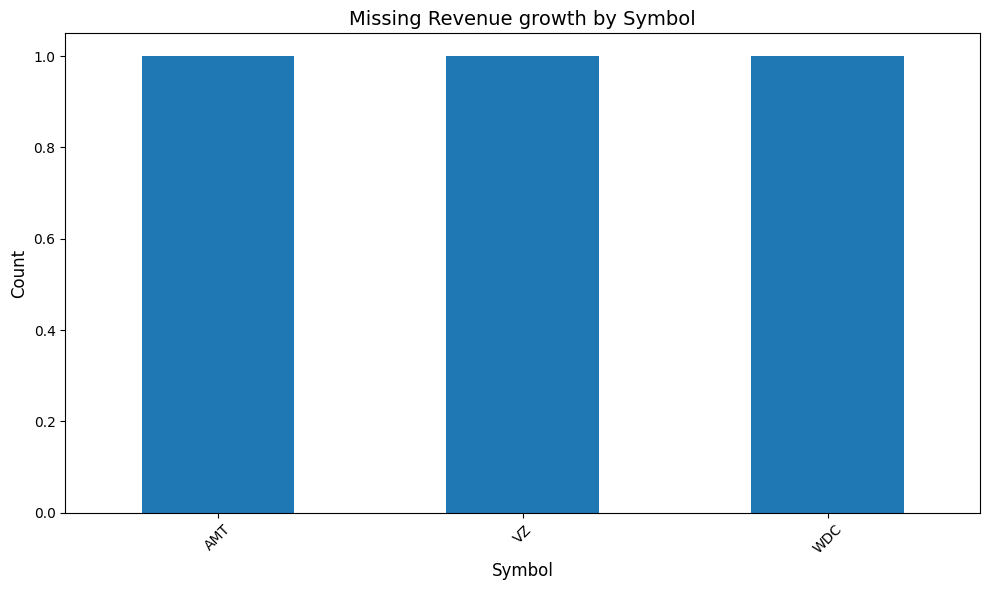

In [48]:
def explore_missing_revenuegrowth(df, df_name="DataFrame"):
    """
    Plots a bar chart of how many rows per company have missing Revenuegrowth values.
    """
    missing_revenuegrowth = df[df['Revenuegrowth'].isnull()].groupby(df['Symbol']).size()

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    missing_revenuegrowth.plot(kind='bar')
    plt.title('Missing Revenue growth by Symbol', fontsize=14)
    plt.xlabel('Symbol', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

explore_missing_revenuegrowth(df_sp500_companies, "S&P500 Companies")



##### Pie chart showing proportion of missing EBITDA values per symbol.

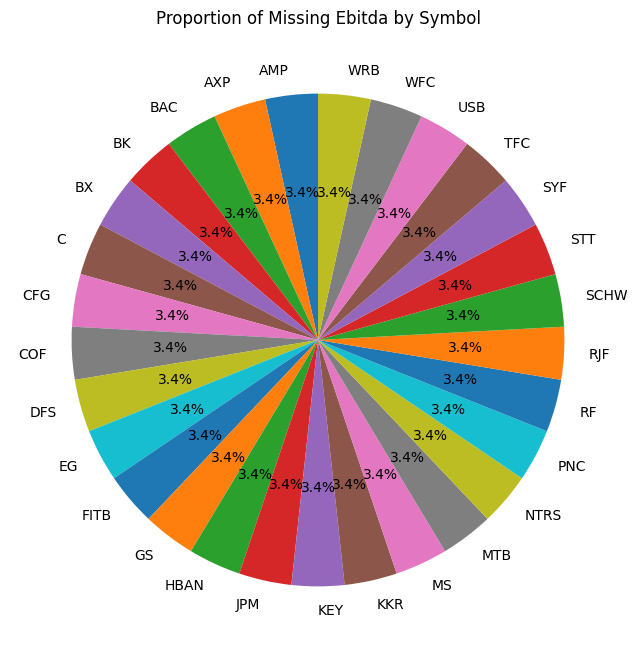

In [49]:
def explore_missing_ebitda(df, df_name="DataFrame"):
    """
    Plots a pie chart representing the proportion of missing EBITDA values by company.
    """
    missing_ebitda = df[df['Ebitda'].isnull()].groupby(df['Symbol']).size()

    missing_ebitda.plot.pie(autopct='%1.1f%%', figsize=(8, 8), startangle=90, legend=False)
    plt.title('Proportion of Missing Ebitda by Symbol')
    plt.ylabel('')
    plt.show()

explore_missing_ebitda(df_sp500_companies, "S&P500 Companies")

#### Shows count and percentage of stocks per stock exchange.

The data is collected from multiple exchanges. Most of them is from NYQ. Other exchanges are NMS, BTS and NGM

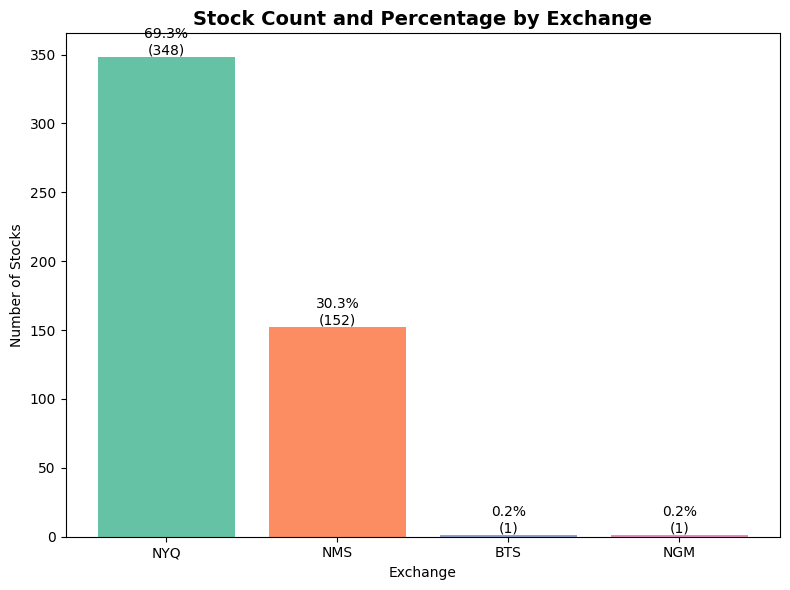

In [50]:
def plot_exchange_distribution_bar(df):
    """
    Bar plot of number and percentage of stocks listed on each stock exchange.
    Includes labels for count and percentage.
    """
    exchange_counts = df['Exchange'].value_counts()
    total = exchange_counts.sum()
    percentages = (exchange_counts / total) * 100

    plt.figure(figsize=(8, 6))
    bars = plt.bar(exchange_counts.index, exchange_counts.values, color=plt.cm.Set2.colors)

    for bar, percentage, count in zip(bars, percentages, exchange_counts.values):
        height = bar.get_height()
        label = f'{percentage:.1f}%\n({count})'
        plt.text(bar.get_x() + bar.get_width() / 2, height, label,
                 ha='center', va='bottom', fontsize=10)

    plt.title('Stock Count and Percentage by Exchange', fontsize=14, weight='bold')
    plt.xlabel('Exchange')
    plt.ylabel('Number of Stocks')
    plt.tight_layout()
    plt.show()
    
plot_exchange_distribution_bar(df_sp500_companies)


##### Pie chart for visualizing how companies are distributed across sectors.

The Technology sector leads with the largest share at 16.3% (82 companies), followed by Industrials (13.9%), Financial Services (13.3%), and Healthcare (12.4%). Other significant contributors include Consumer Cyclical (11.0%) and Consumer Defensive (7.4%). Less represented sectors such as Utilities, Real Estate, Communication Services, Energy, and Basic Materials each contribute around 4–6%. This distribution highlights the tech-heavy composition of the index, reflecting current market dynamics and investor focus.

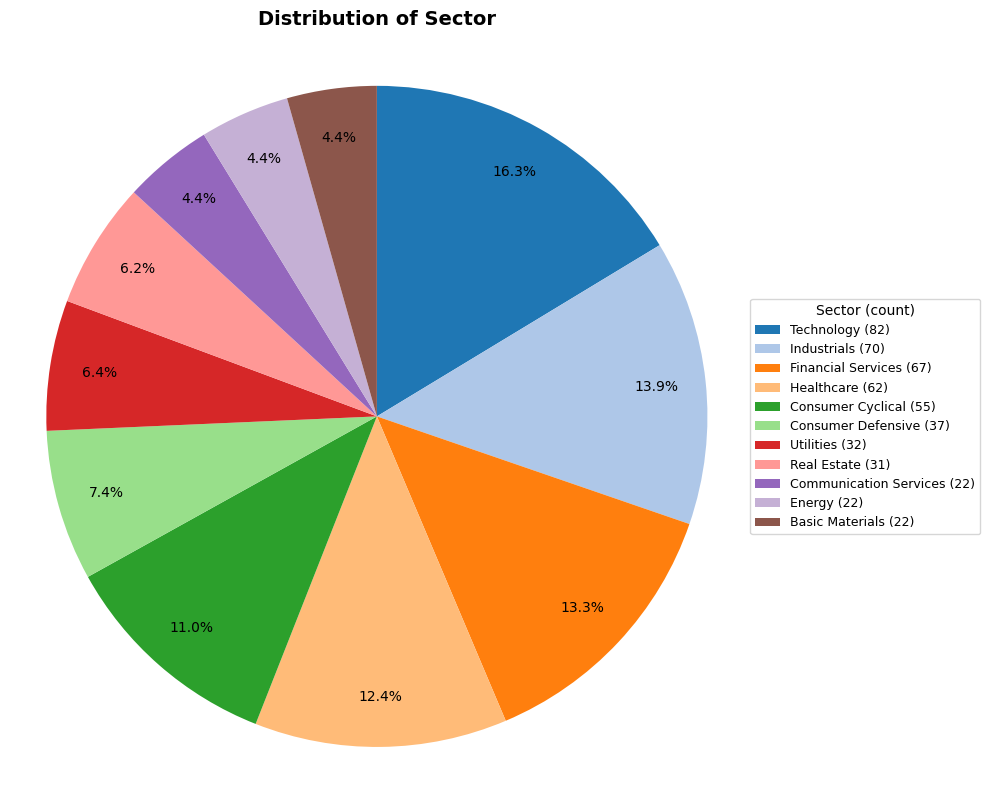

In [51]:
def plot_category_pie_chart(df, column_name, title=None):
    """
    Creates a pie chart showing the distribution and count of categories in a specified column.
    """
    category_counts = df[column_name].value_counts()
    labels = [f"{cat} ({count})" for cat, count in zip(category_counts.index, category_counts.values)]

    fig, ax = plt.subplots(figsize=(10, 8))
    wedges, texts, autotexts = ax.pie(
        category_counts,
        labels=None,
        autopct=lambda pct: f"{pct:.1f}%",  # Show only % inside
        startangle=90,
        counterclock=False,
        pctdistance=0.85,
        colors=plt.cm.tab20.colors
    )

    ax.legend(
        wedges,
        labels,
        title=f'{column_name} (count)',
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        fontsize=9
    )

    ax.set_title(title if title else f'Distribution of {column_name}', pad=20, fontsize=14, weight='bold')
    ax.axis('equal')
    plt.tight_layout()
    plt.show()


plot_category_pie_chart(df_sp500_companies, 'Sector')


### Normal and log1p transformation comparision. Applies log1p to Revenuegrowth and Ebitda and visualizes skewness reduction.

Revenue Growth Distribution
KDE plot compares the original and log1p-transformed distributions of the Revenuegrowth feature.
The transformation reduces skewness and compresses extreme values, centering the distribution more tightly around 0.
The transformation retains the shape but narrows the peak, which helps stabilize variance and make the feature more suitable for machine learning models.
log1p transformation effectively normalizes the Revenuegrowth distribution, especially useful when dealing with skewed data in regression or clustering tasks.


Ebitda Distribution
This density plot shows a large spike at zero after applying log1p on the Ebitda feature.
The original Ebitda values exhibit a wide range (long tail), while the transformed values are significantly compressed.
The transformed distribution becomes sharply peaked, suggesting a large concentration of small or zero EBITDA values.

C:\Users\atul1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


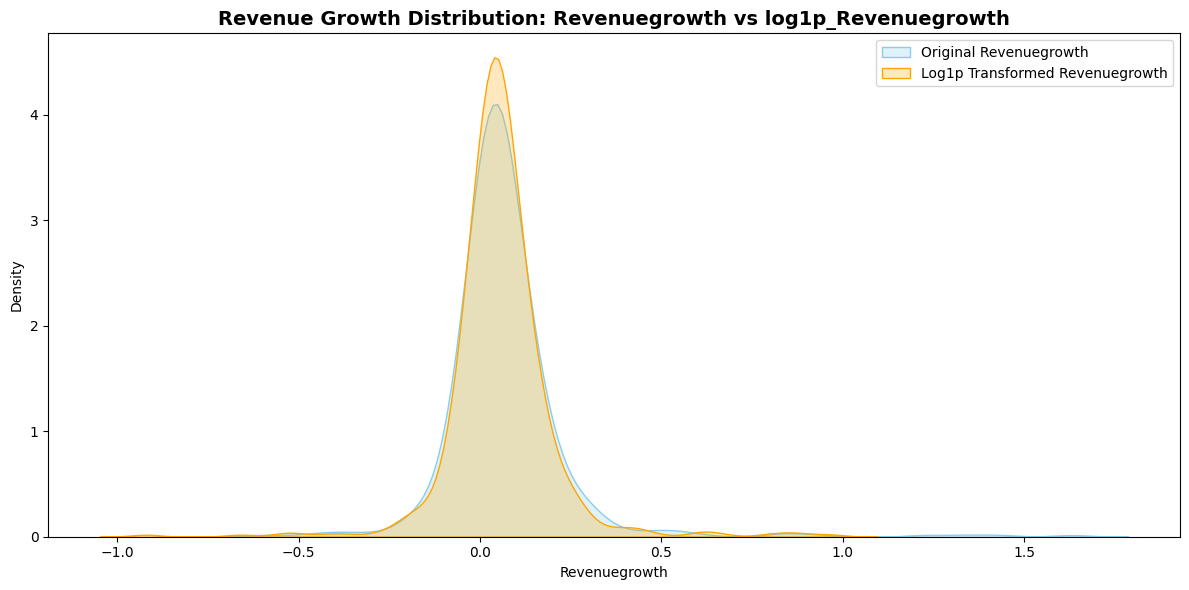

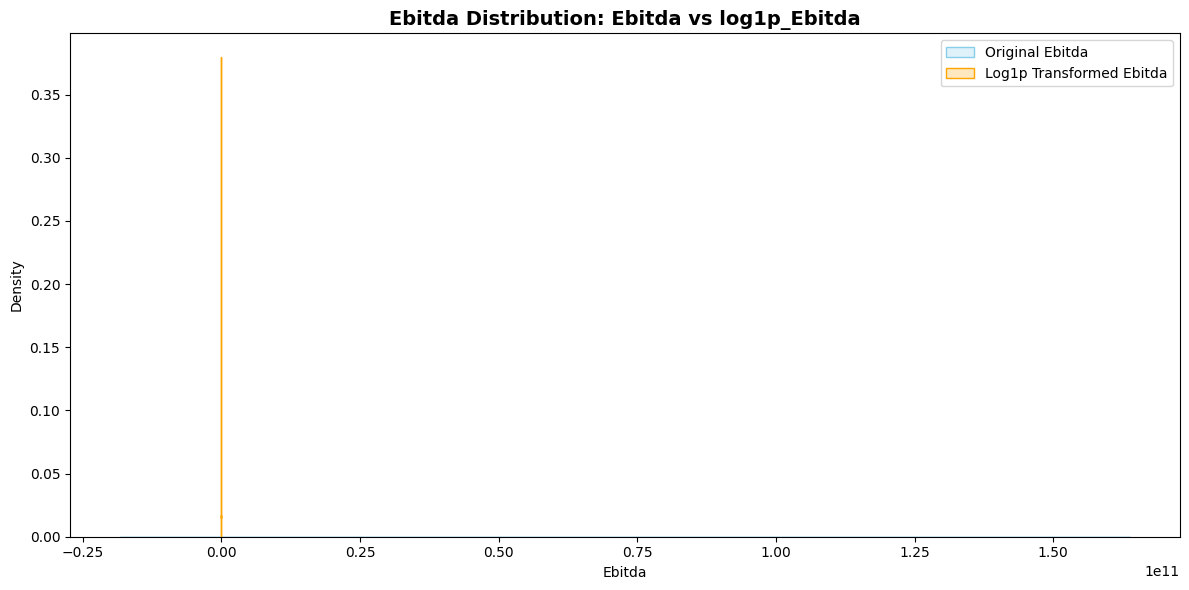

In [52]:

def apply_log1p_transform(df, columns, inplace=True):
    """
    Applies log1p transformation to specified columns.
    Adds new columns prefixed with "log1p_" for transformed values.
    """
    if not inplace:
        df = df.copy()

    for col in columns:
        # Calculate log1p and create new columns
        new_col = f"log1p_{col}"
        df[new_col] = np.log1p(df[col])
    
    return df

def visualize_log1p_transformation(df, column, log_column, title_prefix=""):
    """
    Visualizes the before and after effect of log1p transformation using KDE plots.
    """
    plt.figure(figsize=(12, 6))
    
    sns.kdeplot(df[column].dropna(), label=f"Original {column}", fill=True, color='skyblue')
    sns.kdeplot(df[log_column].dropna(), label=f"Log1p Transformed {column}", fill=True, color='orange')

    plt.title(f"{title_prefix} Distribution: {column} vs {log_column}", fontsize=14, weight='bold')
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
df_companies_and_stock = apply_log1p_transform(df_sp500_companies, ['Revenuegrowth', 'Ebitda'])
visualize_log1p_transformation(df_companies_and_stock, 'Revenuegrowth', 'log1p_Revenuegrowth', title_prefix="Revenue Growth")
visualize_log1p_transformation(df_companies_and_stock, 'Ebitda', 'log1p_Ebitda', title_prefix="Ebitda")


## Time series plot of S&P 500 index, optionally filtered by recent N years.

TLine chart displays the daily closing values of the S&P 500 index from 2015 to the end of 2024.
The overall trend is upward, indicating a long-term bullish market performance. The chart captures key economic events, such as the sharp dip in early 2020 and the subsequent rapid recovery.
Post-2020, the index shows accelerated growth, though interspersed with corrections and volatile phases. As of 2024, the index has surpassed 6000 points, marking a significant rise from ~2000 in 2015.
The S&P 500 has demonstrated robust growth over the last decade, with occasional drawdowns. This long-term uptrend underscores investor confidence and broad economic resilience, making it a valuable benchmark for market health.

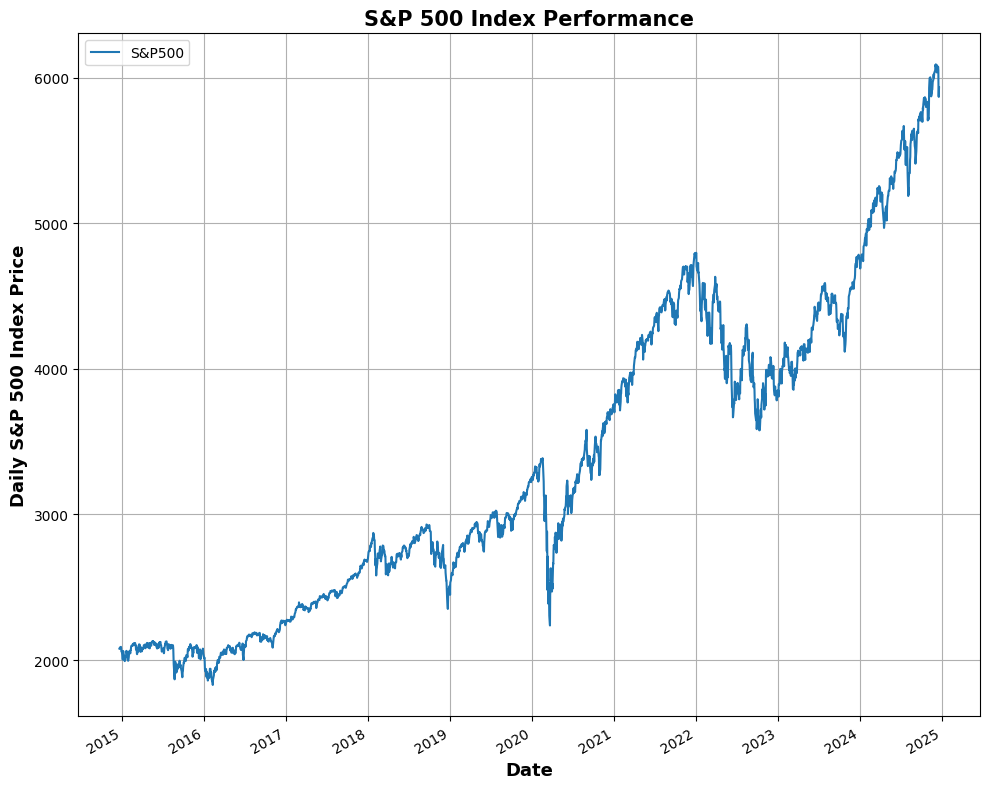

In [53]:
def plot_sp500_performance(sp_500_index, num_years=None):
    """
    Plots historical S&P 500 index values. If num_years is specified,
    filters to the most recent N years.
    """
    if 'Year' not in sp_500_index.columns:
        sp_500_index['Year'] = sp_500_index['Date'].dt.year

    # Filter data based on year
    if num_years:
        latest_year = sp_500_index['Year'].max()
        filtered_df = sp_500_index[sp_500_index['Year'] >= (latest_year - num_years)]
    else:
        filtered_df = sp_500_index

    # Plot
    ax = filtered_df[['Date', 'S&P500']].set_index('Date').plot(figsize=(10, 8))
    plt.title("S&P 500 Index Performance", weight='bold', fontsize=15)
    ax.set_xlabel("Date", weight='bold', fontsize=13)
    ax.set_ylabel("Daily S&P 500 Index Price", weight='bold', fontsize=13)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_sp500_performance(df_sp500_index)

# Heatmap showing pairwise correlations between numeric features.

The heatmap visualizes pairwise Pearson correlation coefficients among numerical features such as market data, financial metrics, and transformed variables.

#### Strong positive correlations are observed between:


Marketcap and Ebitda (0.85), indicating that larger companies tend to report higher earnings.


Marketcap and Weight (1.00), which is expected as index weight is typically based on market capitalization.


Revenuegrowth and log1p_Revenuegrowth (0.96) as the latter is a monotonic transformation.


Ebitda and log1p_Ebitda (0.68) reflect consistent transformation behavior.



Fulltimeemployees shows moderate correlation with Ebitda (0.40) and Marketcap (0.34), suggesting that larger firms employ more staff and generate higher earnings. Currentprice is weakly correlated with all variables, including Marketcap (0.05) and Revenuegrowth (0.04), implying price alone doesn’t capture fundamental size or growth. Weight correlates moderately with log1p_Ebitda (0.52), hinting at influence of earnings on index weight. Most other pairwise relationships exhibit low correlation, highlighting diverse financial behavior across companies. Overall, the matrix confirms expected financial trends while justifying the use of multiple features for deeper analysis and modeling. This insight can guide feature selection and dimensionality reduction techniques like PCA by identifying redundant variables.

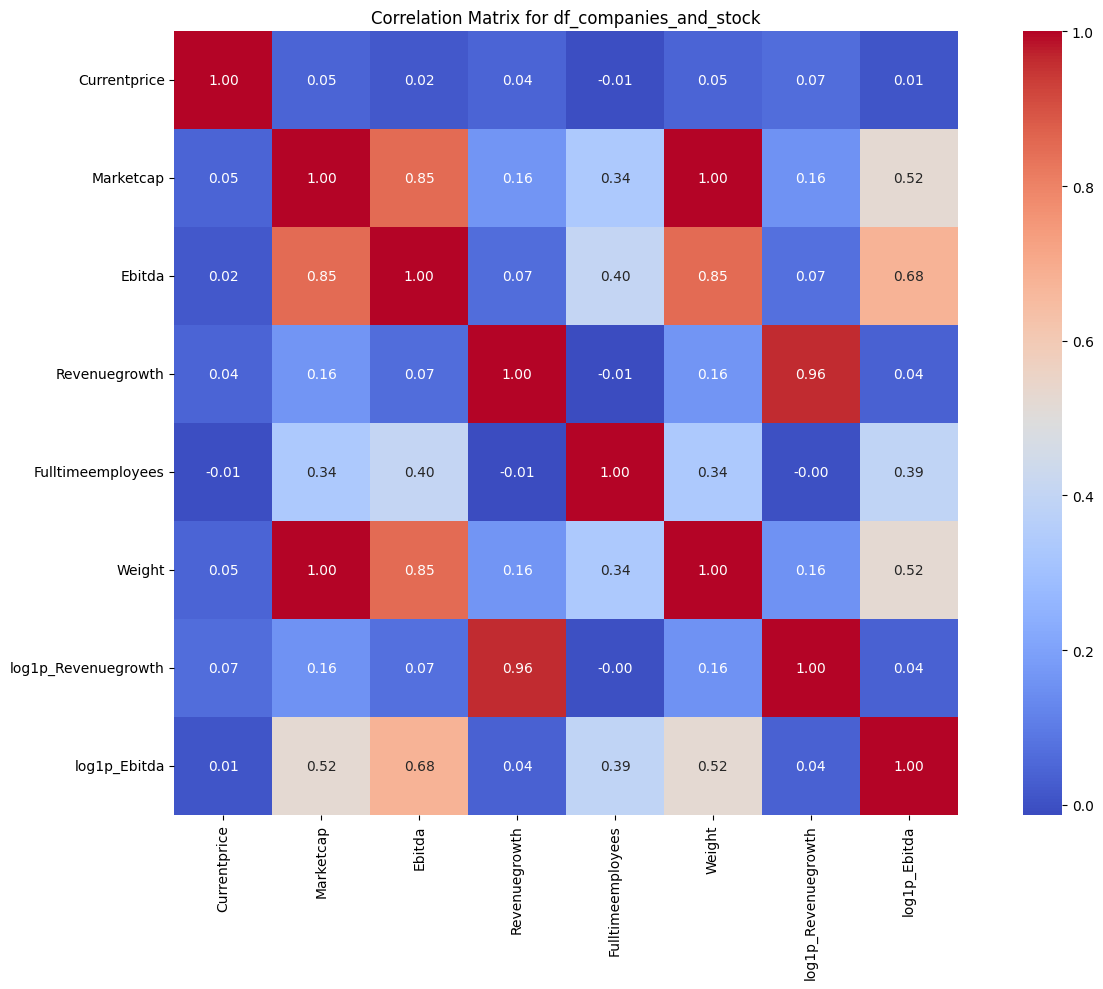

In [54]:
def plot_correlation_matrix(df, df_name="DataFrame"):
    """
    Plots a heatmap of the correlation matrix for numeric columns in the DataFrame.
    """
    corr = df.select_dtypes(include=['float64', 'int64']).corr()
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title(f'Correlation Matrix for {df_name}')
    plt.tight_layout()
    plt.show()
    
plot_correlation_matrix(df_companies_and_stock, "df_companies_and_stock")


# Grid of scatter plots and histograms to explore pairwise relationships.

The pair plot visually compares all combinations of numeric features such as Currentprice, Marketcap, Ebitda, Revenuegrowth, and their log-transformed versions. Strong linear relationships are evident between Marketcap and Ebitda, and also between features and their log1p counterparts. The log-transformed features show more symmetric and narrow distributions, indicating successful normalization of skewed data. Most scatter plots show non-linear or weak linear relationships, especially those involving Currentprice, Fulltimeemployees, or Weight. High dispersion in plots like Ebitda vs Revenuegrowth suggests variability across sectors or companies of different sizes. Several plots reveal outliers, particularly for Marketcap and Ebitda, which could skew statistical models if unaddressed. Revenuegrowth appears to have a tightly packed distribution, possibly due to its limited range after removing negative values.

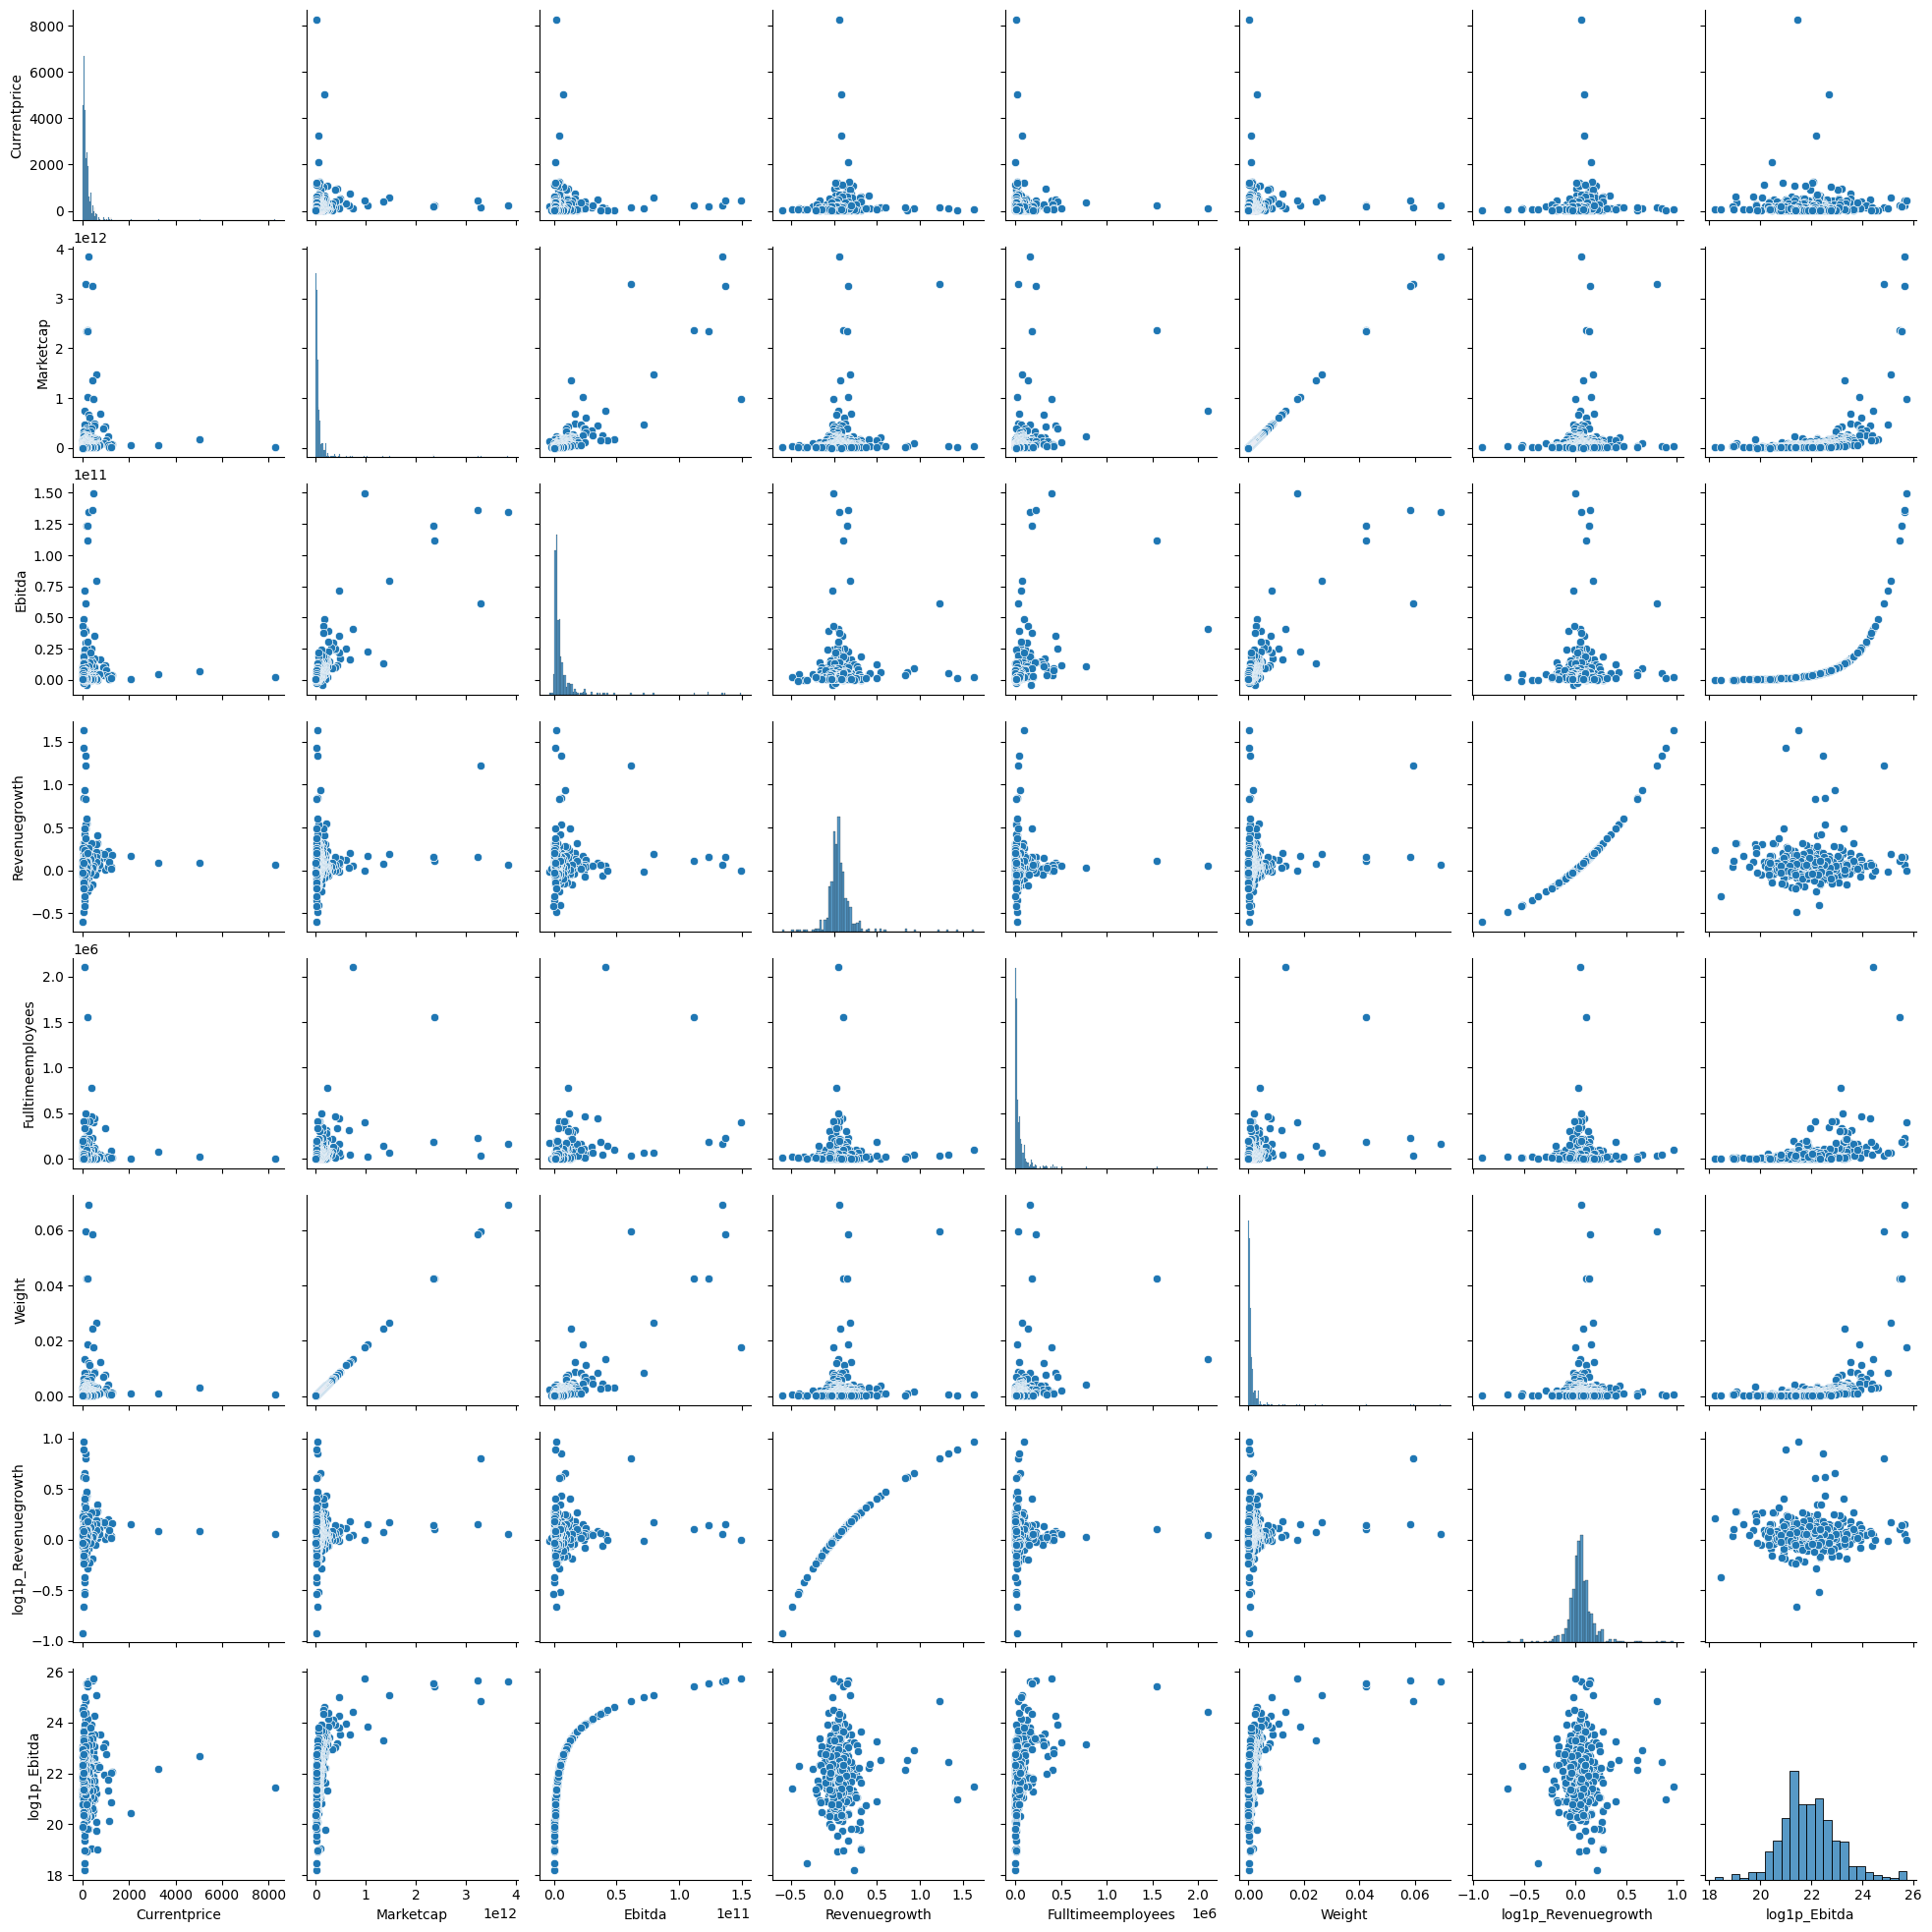

In [55]:
sns.pairplot(df_companies_and_stock) 
plt.show()

# Plots how stock prices compare against the index after normalization.

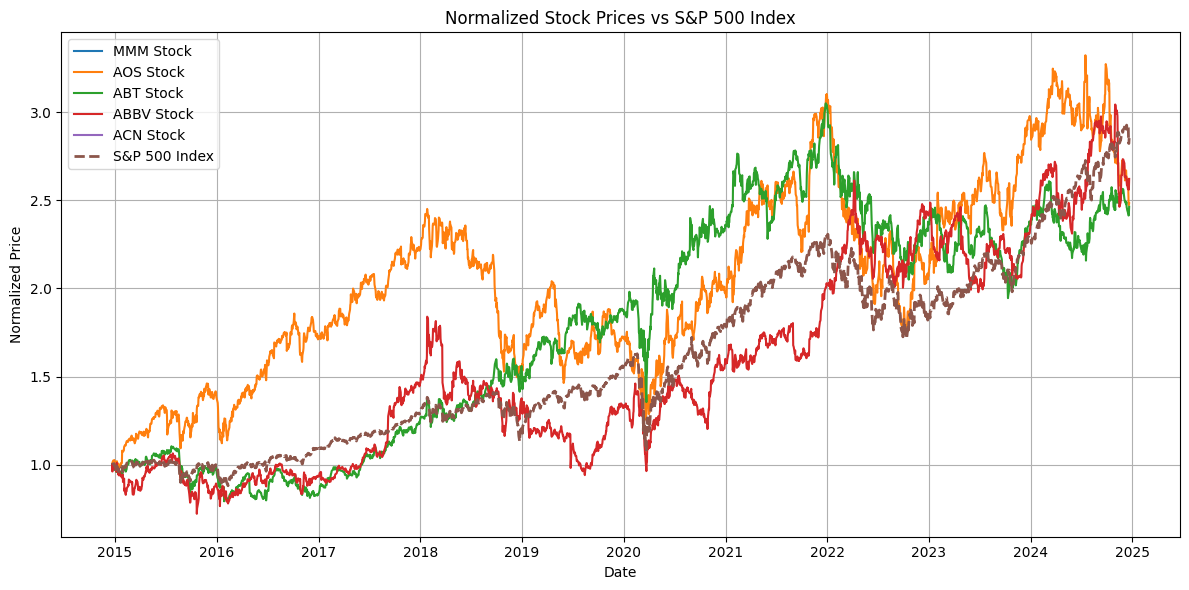

In [56]:

def plot_index_vs_stocks(df_stock, df_index, symbols):
    """
    Plots normalized prices of selected stock symbols vs normalized S&P 500 index
    to show relative performance.
    """
    plt.figure(figsize=(12, 6))

    for symbol in symbols:
        df_stock_filtered = df_stock[df_stock['Symbol'] == symbol].copy()
        df = pd.merge(df_stock_filtered, df_index, on='Date', how='inner')

        if df.empty:
            print(f"No data found for symbol: {symbol}")
            continue

        # Normalize stock and index values for comparison
        # Normalized price = current / first available price
        df['Normalized_Close'] = df['Close'] / df['Close'].iloc[0]
        df['Normalized_S&P500'] = df['S&P500'] / df['S&P500'].iloc[0]

        plt.plot(df['Date'], df['Normalized_Close'], label=f'{symbol} Stock')

    # Plot S&P 500 only once using any non-empty merge
    first_symbol_df = df_stock[df_stock['Symbol'] == symbols[0]].copy()
    df_index_plot = pd.merge(first_symbol_df, df_index, on='Date', how='inner')
    if not df_index_plot.empty:
        df_index_plot['Normalized_S&P500'] = df_index_plot['S&P500'] / df_index_plot['S&P500'].iloc[0]
        plt.plot(df_index_plot['Date'], df_index_plot['Normalized_S&P500'], label='S&P 500 Index', linestyle='--', linewidth=2)

    plt.title(f'Normalized Stock Prices vs S&P 500 Index')
    plt.xlabel('Date')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_index_vs_stocks(df_sp500_stocks, df_sp500_index, df_sp500_stocks['Symbol'].unique()[:5])

# Line chart comparing stock return vs index return.

The line plot compares daily return volatility. For this We used just one compeny ALB from 2015 to 2025. ALB returns (blue line) exhibit significantly higher fluctuations and spikes, indicating greater volatility compared to the broader market. The S&P 500 (orange line) shows relatively stable returns clustered around zero, characteristic of a diversified index.

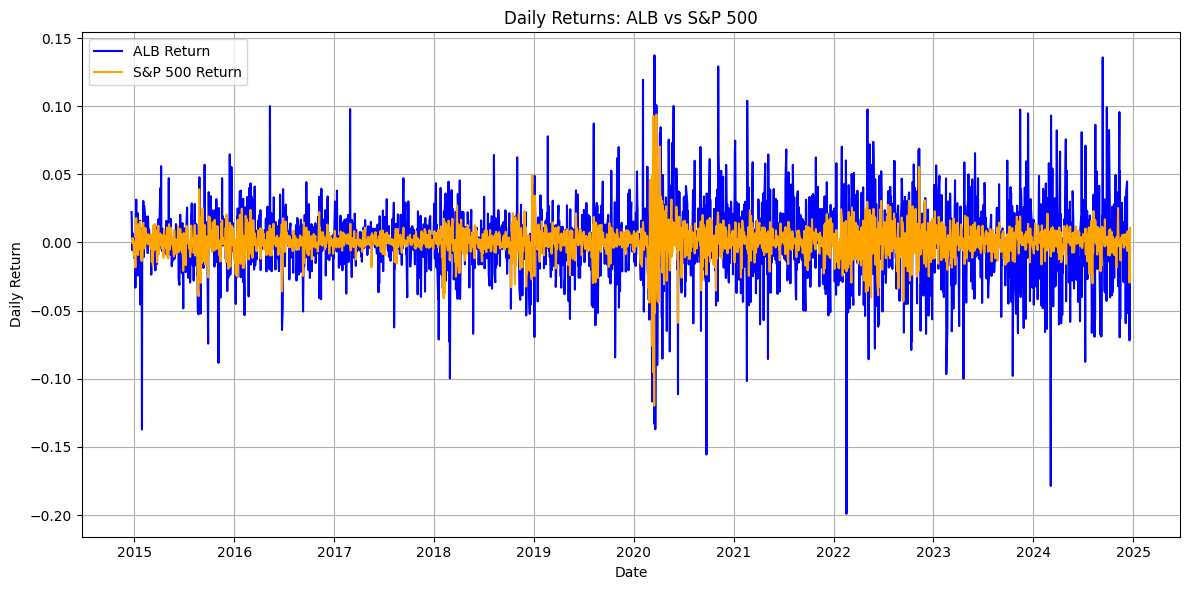

In [57]:
def plot_return_comparison(df_stock, df_index, symbol):
    """
    Compares daily return percentages between a single stock and the S&P 500 index.
    """
    df_symbol = df_stock[df_stock['Symbol'] == symbol].copy()
    df_symbol = df_symbol[['Date', 'Close']].dropna()
    df_symbol['Date'] = pd.to_datetime(df_symbol['Date'])
    df_symbol = df_symbol.sort_values('Date')
    df_symbol['Return'] = df_symbol['Close'].pct_change()

    df_index = df_index.copy()
    df_index = df_index[['Date', 'S&P500']].dropna()
    df_index['Date'] = pd.to_datetime(df_index['Date'])
    df_index = df_index.sort_values('Date')
    df_index['Return'] = df_index['S&P500'].pct_change()

    # Merge on date
    df_merged = pd.merge(df_symbol, df_index, on='Date', how='inner', suffixes=('_stock', '_index'))

    plt.figure(figsize=(12, 6))
    plt.plot(df_merged['Date'], df_merged['Return_stock'], label=f'{symbol} Return', color='blue')
    plt.plot(df_merged['Date'], df_merged['Return_index'], label='S&P 500 Return', color='orange')
    plt.title(f'Daily Returns: {symbol} vs S&P 500')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_return_comparison(df_sp500_stocks, df_sp500_index, 'ALB')
# df_sp500_companies, df_sp500_index, df_sp500_stocks = load_sp500_data(SNP500_COMPANIES_FILE_PATH, SNP500_INDEX_FILE_PATH, SNP500_STOCKS_FILE_PATH)
